## Import libraries  & loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/dslab"

/content/drive/MyDrive/dslab


In [ ]:
import re
import nltk
import string
import pandas as pd
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset=pd.read_csv('labeled_data.csv')
dataset


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Data Analysis

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


Text(0, 0.5, 'Number of Tweets')

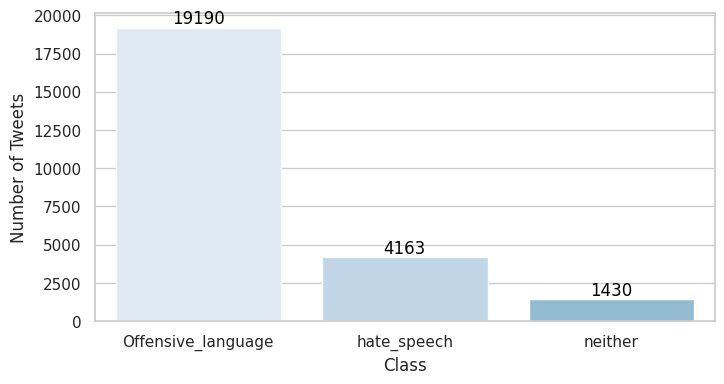

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_labels = ['Offensive_language', 'hate_speech', 'neither']
class_counts = dataset['class'].value_counts()
sns.set(style="whitegrid")
sns.set_palette("Blues")
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=class_labels, y=class_counts, ax=ax)
for bar, count in zip(ax.patches, class_counts):
    ax.annotate(f'{count}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom', color='black', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)


Number of Hate Speech Tweets: 19190

Number of Offensive Language Tweets: 4163

Number of Neither Tweets: 1430

In [ ]:
missing=dataset.isnull().sum()
print(missing)

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


 No null values





#Preprocessing

In [ ]:
tweet=dataset.tweet

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stopwords.remove('not')
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

     # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])



    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets
print(dataset[["tweet","processed_tweets"]].head(10))

<ipython-input-10-c6bbfca7ca82>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
<ipython-input-10-c6bbfca7ca82>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=punc_remove.str.replace(r'\s+', ' ')
<ipython-input-10-c6bbfca7ca82>:34: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
<ipython-input-10-c6bbfca7ca82>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

In [ ]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6689 sparse matrix of type '<class 'numpy.float64'>'
	with 199550 stored elements in Compressed Sparse Row format>

In [ ]:
from pandas.core.frame import DataFrame
p=DataFrame(tfidf)

In [ ]:
p.head()

,0
0,"(0, 5671)\t0.4309517500614609\n (0, 6008)\t..."
1,"(0, 1477)\t0.35408569797294004\n (0, 4505)\..."
2,"(0, 748)\t0.4047434652361727\n (0, 2142)\t0..."
3,"(0, 3466)\t0.6524605586008377\n (0, 3579)\t..."
4,"(0, 775)\t0.42764555354525047\n (0, 6586)\t..."


In [ ]:
X = tfidf
y = dataset['class'].astype(int)



In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state =42)

X_res, y_res = sm.fit_resample(X,y)


In [ ]:
print("class 0 : {}".format(sum(y_res== 0)))
print("class 1 : {}".format(sum(y_res== 1)))
print("class 2 : {}".format(sum(y_res== 2)))

class 0 : 19190
class 1 : 19190
class 2 : 19190
